In [11]:
import warnings

import bionty as bt
import lamindb as ln
import spatialdata as sd
import spatialdata_plot as sdp

warnings.filterwarnings("ignore")

# Query and download datasets from spatialdata-db

Spatialdata-db is based on [lamin](https://docs.lamin.ai/introduction) - a framework to organize and structure biological datasets and experiments.
To be able to search for datasets and download them, first we need to specify the data ressource that we want to work with:

In [2]:
!lamin connect scverse/spatialdata-db

! the database (1.1a1) is ahead of your installed lamindb package (1.0.5)
→ please update lamindb: pip install "lamindb>=1.1,<1.2"
→ connected lamindb: scverse/spatialdata-db


### Brief intro to lamin artifacts

TL;DR:
- lamin artifact = `spatialdata` dataset + metadata + dataset version history

Lamindb Artifacts are versioned, structured data objects that track and manage files in computational biology workflows. They function like "Git for data," enabling reproducible storage, retrieval, and linking of datasets to each other and the code used for processing.

Each dataset tracked with Lamin is enriched with metadata, including its creator, creation time, version history, and links to the processing code. These enriched data objects are then stored as Artifacts, ensuring traceability and reproducibility.

Further reading:
- https://docs.lamin.ai/tutorial
- https://docs.lamin.ai/lamindb.artifact

### How to search for datasets
 
The following will show an overview of useful query options, but more information and a longer introduction can be found on [Lamin query & search](https://docs.lamin.ai/registries).

Currently, the database can be searched for:
- organism
- tissue
- disease
- assay
- data_provider
- chemistry_version
- preproc_version
- license

Where organism, tissue, disease and assay are linked to public ontologies that can be accessed via [`bionty`](https://docs.lamin.ai/bionty).
Lookups provide an overview of which values are present for each feature:

In [3]:
tissues = bt.Tissue.lookup()
organisms = bt.Organism.lookup()
organisms.dict()

{'human': Organism(uid='1dpCL6Td', name='human', ontology_id='NCBITaxon:9606', scientific_name='homo_sapiens', created_by_id=2, space_id=1, source_id=1, created_at=2024-04-02 08:47:47 UTC),
 'mouse': Organism(uid='3RZqbcSL', name='mouse', ontology_id='NCBITaxon:10090', scientific_name='mus_musculus', created_by_id=7, space_id=1, source_id=1, created_at=2024-05-03 14:45:45 UTC)}

In [5]:
organisms.mouse

Organism(uid='3RZqbcSL', name='mouse', ontology_id='NCBITaxon:10090', scientific_name='mus_musculus', created_by_id=7, space_id=1, source_id=1, created_at=2024-05-03 14:45:45 UTC)

To query for datasets (= artifacts) use `ln.Artifact.filter`, which returns a list of artifacts:

In [6]:
query = ln.Artifact.filter(
    organisms=organisms.mouse,
    tissues=tissues.brain,
)

We get an overview of the aritfacts that match the search criteria via `query.df()` which return a dataframe of all results with:
- the unique identifier (uid)
- the virtual key, which can be ignored for now
- the description text that was provided by the person that uploaded the dataset
- the type of the dataset - here we'll always have `spatialdata` objects



In [28]:
query.df(include=['otype'])

,uid,key,description,otype
id,,,,
272,wg5zQhHX5cQ9UG4N0000,None,"10X, Visium, Mouse, unknown, brain, 2020",spatialdata
222,ubllg1iYQBaiDJfW0000,None,"10X, VisiumHD, Mouse, Healthy, Brain, 2024",spatialdata
284,AqRfNjb1YHyMDZt00000,None,"10X, Visium, Mouse, healthy, brain, 2022",spatialdata
298,wlgPi3jjfVoYUWjA0000,None,"10X, Visium, Mouse, healthy, brain, 2023",spatialdata
268,SYTEY2CR0OfTdq4N0000,None,"10X, Visium, Mouse, unknown, brain, 2019",spatialdata
270,8Xdm6p3J8FPOxok00000,None,"10X, Visium, Mouse, unknown, brain, 2020",spatialdata
271,KgUohDusDLA4S6WW0000,None,"10X, Visium, Mouse, unknown, brain, 2020",spatialdata
269,McoRBaiIuHp0Q8RQ0000,None,"10X, Visium, Mouse, healthy, brain, 2022",spatialdata
288,4gLfyEWea7fJpXyQ0000,None,"10X, Visium, Mouse, unknown, brain, 2020",spatialdata


 and can select individual artifact either via list index, e.g. `query[1]`, or using the artifact uid `ln.Artifact.get('ubllg1iYQBaiDJfW0000')`. 

In [ ]:
ln.Artifact.get("wg5zQhHX5cQ9UG4N0000")

Artifact(uid='wg5zQhHX5cQ9UG4N0000', is_latest=True, description='10X, Visium, Mouse, unknown, brain, 2020', suffix='.zarr', otype='spatialdata', size=57953090, hash='raOCaxJLh_weCxY7z4mu3w', n_files=327, space_id=1, storage_id=2, run_id=244, created_by_id=8, created_at=2025-01-19 21:29:00 UTC)

In [24]:
artifact = query[0]  # == ln.Artifact.get('wg5zQhHX5cQ9UG4N0000')
artifact

Artifact(uid='wg5zQhHX5cQ9UG4N0000', is_latest=True, description='10X, Visium, Mouse, unknown, brain, 2020', suffix='.zarr', otype='spatialdata', size=57953090, hash='raOCaxJLh_weCxY7z4mu3w', n_files=327, space_id=1, storage_id=2, run_id=244, created_by_id=8, created_at=2025-01-19 21:29:00 UTC)

Instead of filtering for sample level metadata, we could also query for datasets that contain the expression of specific genes, e.g the expression of 'Gfap':

In [4]:
ln.Artifact.filter(feature_sets__genes__symbol="Gfap").df()

,uid,key,description,suffix,kind,otype,size,hash,n_files,n_observations,_hash_type,_key_is_virtual,_overwrite_versions,space_id,storage_id,schema_id,version,is_latest,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,,,,,,,,,,,
222,ubllg1iYQBaiDJfW0000,None,"10X, VisiumHD, Mouse, Healthy, Brain, 2024",.zarr,None,spatialdata,1099865189,r3sSzfkOliLFFfhDzmP9hw,2215,None,md5-d,True,True,1,2,None,None,True,197.0,2024-12-16 10:07:09.710482+00:00,8,None,1
268,SYTEY2CR0OfTdq4N0000,None,"10X, Visium, Mouse, unknown, brain, 2019",.zarr,None,spatialdata,56180342,pgkbcq_Rhf24MfhY-1zc1Q,327,None,md5-d,True,True,1,2,None,None,True,NaN,2025-01-19 21:19:25.551402+00:00,8,None,1
269,McoRBaiIuHp0Q8RQ0000,None,"10X, Visium, Mouse, healthy, brain, 2022",.zarr,None,spatialdata,54841203,PlYRrY4VI-frNKHES5gvqw,327,None,md5-d,True,True,1,2,None,None,True,240.0,2025-01-19 21:23:37.660374+00:00,8,None,1
270,8Xdm6p3J8FPOxok00000,None,"10X, Visium, Mouse, unknown, brain, 2020",.zarr,None,spatialdata,38143587,1SFkEeE1UvvswCpuCstDPw,327,None,md5-d,True,True,1,2,None,None,True,241.0,2025-01-19 21:25:28.550886+00:00,8,None,1
271,KgUohDusDLA4S6WW0000,None,"10X, Visium, Mouse, unknown, brain, 2020",.zarr,None,spatialdata,38143587,Xdl3V5khe8508IjaJQhm8g,327,None,md5-d,True,True,1,2,None,None,True,241.0,2025-01-19 21:26:41.761595+00:00,8,None,1
272,wg5zQhHX5cQ9UG4N0000,None,"10X, Visium, Mouse, unknown, brain, 2020",.zarr,None,spatialdata,57953090,raOCaxJLh_weCxY7z4mu3w,327,None,md5-d,True,True,1,2,None,None,True,244.0,2025-01-19 21:29:00.556320+00:00,8,None,1
284,AqRfNjb1YHyMDZt00000,None,"10X, Visium, Mouse, healthy, brain, 2022",.zarr,None,spatialdata,54817400,NTOnZzCUoYiXjypzHEud7g,327,None,md5-d,True,True,1,2,None,None,True,239.0,2025-01-19 21:45:48.348520+00:00,8,None,1
288,4gLfyEWea7fJpXyQ0000,None,"10X, Visium, Mouse, unknown, brain, 2020",.zarr,None,spatialdata,54817412,yocuS6gw1aoX2zwDNZsebg,327,None,md5-d,True,True,1,2,None,None,True,243.0,2025-01-19 21:51:51.708790+00:00,8,None,1
298,wlgPi3jjfVoYUWjA0000,None,"10X, Visium, Mouse, healthy, brain, 2023",.zarr,None,spatialdata,116459181,Ss6q2vgfyG3ARYWp0SUmsg,443,None,md5-d,True,True,1,2,None,None,True,252.0,2025-01-21 14:17:50.268625+00:00,8,None,1


But for now, let's continue with the dataset that we selected earlier. We can now cache the dataset, to download and store it locally:

In [25]:
path_to_stored_data = artifact.cache()

... synchronizing wg5zQhHX5cQ9UG4N.zarr: 100.0%
! run input wasn't tracked, call `ln.track()` and re-run


In [ ]:
sdata = sd.read_zarr(
    path_to_stored_data
)
sdata

SpatialData object, with associated Zarr store: /ictstr01/home/icb/lea.zimmermann/.cache/lamindb/scverse-spatial-eu-central-1/.lamindb/wg5zQhHX5cQ9UG4N.zarr
├── Images
│     ├── 'V1_Mouse_Brain_Sagittal_Anterior_full_image': DataTree[cyx] (3, 1998, 2000), (3, 999, 1000), (3, 499, 500), (3, 249, 250), (3, 124, 125)
│     ├── 'V1_Mouse_Brain_Sagittal_Anterior_hires_image': DataArray[cyx] (3, 1998, 2000)
│     └── 'V1_Mouse_Brain_Sagittal_Anterior_lowres_image': DataArray[cyx] (3, 600, 600)
├── Shapes
│     └── 'V1_Mouse_Brain_Sagittal_Anterior': GeoDataFrame shape: (2695, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (2695, 32285)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        V1_Mouse_Brain_Sagittal_Anterior_hires_image (Images), V1_Mouse_Brain_Sagittal_Anterior (Shapes)
    ▸ 'downscaled_lowres', with elements:
        V1_Mouse_Brain_Sagittal_Anterior_lowres_image (Images), V1_Mouse_Brain_Sagittal_Anterior (Shapes)
    ▸ 'global', with elements:
      

Now for a quick first look into the data sample:

INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02617801..1.0].


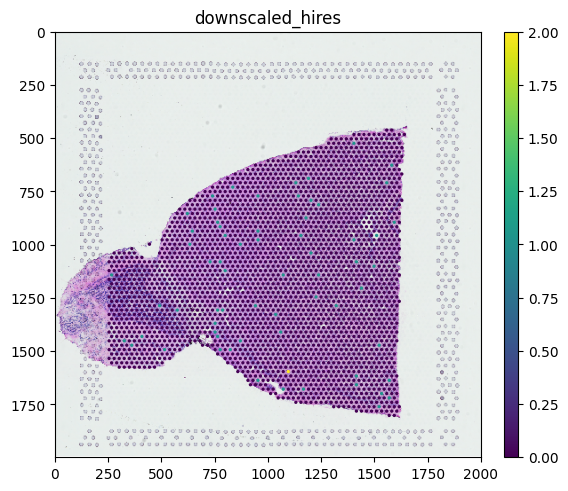

In [ ]:
(
    sdata
    .pl.render_images(elements="V1_Mouse_Brain_Sagittal_Anterior_hires_image")
    .pl.render_shapes(elements="V1_Mouse_Brain_Sagittal_Anterior", color="ENSMUSG00000051951")
    .pl.show("downscaled_hires")
)